In [1]:
import pandas as pd

file_path = 'xgboost_all_periods.parquet'
df = pd.read_parquet(file_path)

df

,Date,Ticker,Return_tomorrow,Target,pred,pred_proba
0,1999-06-25,AAPL,0.008848,1,1,0.551953
1,1999-06-25,ABMD,-0.027577,0,0,0.472160
2,1999-06-25,ABT,0.007118,0,0,0.495372
3,1999-06-25,ACGL,-0.037271,0,0,0.495695
4,1999-06-25,ADBE,0.026629,1,0,0.451522
...,...,...,...,...,...,...
171163,2024-04-26,YUM,0.009966,1,1,0.511693
171164,2024-04-26,ZBH,0.019581,1,1,0.500276
171165,2024-04-26,ZBRA,0.009377,1,0,0.479769
171166,2024-04-26,ZION,-0.010592,0,0,0.491309


In [2]:
import numpy as np
# 首先计算上下5%的阈值
lower_bound = np.percentile(df["Return_tomorrow"], 0.5)
upper_bound = np.percentile(df["Return_tomorrow"], 99.5)

# 然后筛选DataFrame的行，保留在上下5%范围内的值
df = df[(df["Return_tomorrow"] >= lower_bound) & (df["Return_tomorrow"] <= upper_bound)]

### 回测一：模型综合性能对比

Fig. 1. Daily performance metrics for long-short portfolios of different sizes: mean return, standard deviation, and directional accuracy from December 1992 until October 2015.

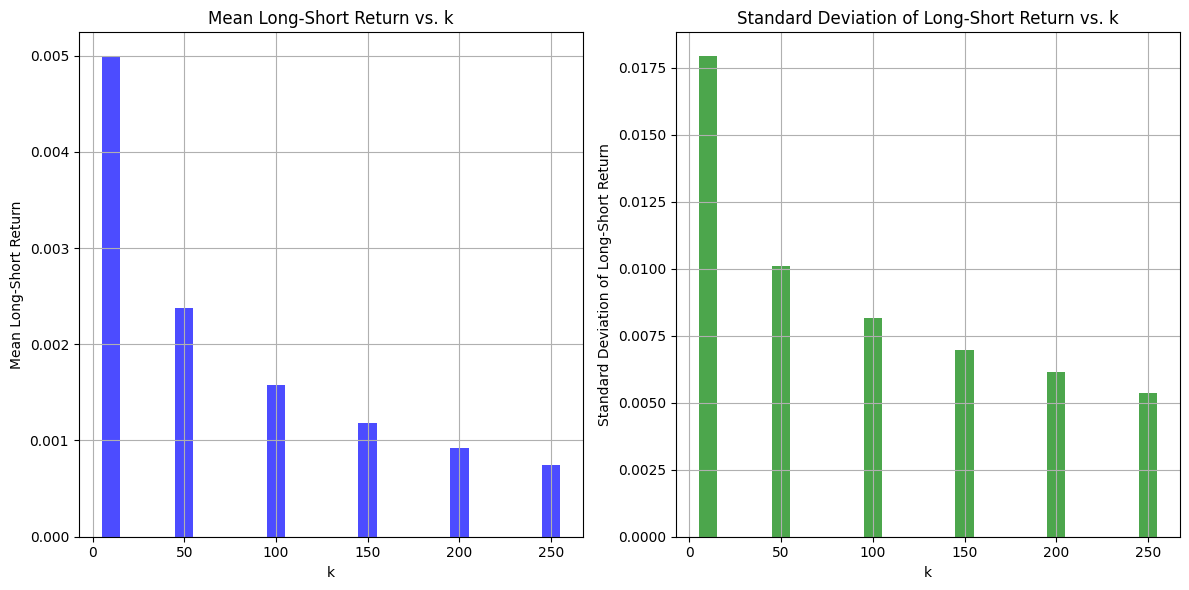

In [182]:
import pandas as pd
import matplotlib.pyplot as plt


# 定义计算多空组合收益的函数
def calculate_long_short_return(group, k):
    long_positions = group.tail(k)
    # print(long_positions)
    short_positions = group.head(k)
    # print(short_positions)

    # 等权重加权
    long_return = long_positions['Return_tomorrow'].sum() / k
    short_return = short_positions['Return_tomorrow'].sum() / k
    long_short_return = long_return - short_return
    
    return pd.Series({'long_return': long_return, 'short_return': short_return, 'long_short_return': long_short_return})

# 创建一个空DataFrame用于存储结果
summary_results = pd.DataFrame(columns=['k', 'mean_long_short_return', 'std_long_short_return'])

# 遍历不同的k值
for k in [10, 50, 100,150, 200, 250]:
    # 对数据进行排序
    df_sorted = df.sort_values(by=['Date', 'pred_proba'])
    
    # 按日期分组并应用计算函数
    results = df_sorted.groupby('Date').apply(calculate_long_short_return, k=k).reset_index()

    # 计算每个k值对应的long_short_return的均值和标准差
    mean_long_short_return = results["long_short_return"].mean()
    std_long_short_return = results["long_short_return"].std()
    
    # 将结果存储到summary_results中
    summary_results = pd.concat([summary_results, pd.DataFrame({'k': [k], 'mean_long_short_return': [mean_long_short_return], 'std_long_short_return': [std_long_short_return]})], ignore_index=True)

# 绘制结果
plt.figure(figsize=(12, 6))

# 绘制均值柱状图
plt.subplot(1, 2, 1)
plt.bar(summary_results['k'], summary_results['mean_long_short_return'], align='center', alpha=0.7, color='blue', width=10)
plt.xlabel('k')
plt.ylabel('Mean Long-Short Return')
plt.title('Mean Long-Short Return vs. k')
plt.grid(True)

# 绘制标准差柱状图
plt.subplot(1, 2, 2)
plt.bar(summary_results['k'], summary_results['std_long_short_return'], align='center', alpha=0.7, color='green', width=10)
plt.xlabel('k')
plt.ylabel('Standard Deviation of Long-Short Return')
plt.title('Standard Deviation of Long-Short Return vs. k')
plt.grid(True)

plt.tight_layout()
plt.show()

### 回测二（日化）：收益-风险特征分析

Table 2 Daily return characteristics of k = 10 portfolio, prior to and after transaction costs for DNN, GBT, RAF, ENS1 compared to general market (MKT) from December 1992 until October 2015. NW denotes Newey–West standard errors with with one-lag correction and PT the Pesaran–Timmermann test.

In [92]:
results['long_short_return'].mean()

0.004242849860892148

In [59]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import empyrical


# 计算指标
mean_return = results['long_short_return'].mean()
mean_return_long = results['long_return'].mean()
mean_return_short = results['short_return'].mean()

std_return = results['long_short_return'].std()
min_return = results['long_short_return'].min()
q1_return = results['long_short_return'].quantile(0.25)
median_return = results['long_short_return'].median()
q3_return = results['long_short_return'].quantile(0.75)
max_return = results['long_short_return'].max()
skewness = results['long_short_return'].skew()
kurtosis = results['long_short_return'].kurtosis()


## t -statistic (NW)
# 计算 Newey-West 标准误差
Y = results['long_short_return']
X = [1] * len(Y)
model = sm.OLS(Y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 6})
std_error_nw = model.bse[0]  # 使用拟合模型中的标准误差
# t 统计量计算
t_statistic_nw = model.tvalues.values[0]


# VaR 和 CVaR 计算
def historical_var(returns, level=5):
    return np.percentile(returns, level)

def historical_cvar(returns, level=5):
    var = historical_var(returns, level)
    return returns[returns <= var].mean()

var_1_percent = historical_var(results['long_short_return'], 1)
var_5_percent = historical_var(results['long_short_return'], 5)

cvar_1_percent = historical_cvar(results['long_short_return'], 1)
cvar_5_percent = historical_cvar(results['long_short_return'], 5)


# 最大回撤计算
#def max_drawdown(returns):
    #net_growth_rates = np.array(returns) + 1
    #net_values = {}
    #drawdown = {}
    #for i in range(len(returns)-1):
        #net_values[i] = np.cumprod(net_growth_rates[i:])
        #drawdown[i] = -(net_values[i][0] - net_values[i].min()) / net_values[i][0]
    #drawdown[len(returns)-1] = returns.iloc[-1]
    #max_drawdown = min(drawdown.values())
    #return -max_drawdown
max_drawdown_value = empyrical.max_drawdown(results["long_short_return"])


# Calmar 比率计算
calmar_ratio = empyrical.annual_return(results['long_short_return'])

# PT 测试统计量（示例）
def pt_test(Y, X):
    import numpy as np
    from scipy.stats import norm
    import collections
    
    #if len(y) != len(yHat):
        #raise Exception("True data and forecast data have different length")
    
    #dy = np.diff(y)
    #dyHat = np.diff(yHat)
    #indicator = lambda x: 1 if x>0 else 0    
    #Y = np.array([i for i in map(indicator, dy)])
    #X = np.array([i for i in map(indicator, dyHat)])
    
    Z = np.array([i for i in map(lambda x: 1 if np.sign(x[0]) ==np.sign(x[1]) else 0, zip(Y,X))])
    #print(X)
    #print(Y)
    #print(Z)
    n = len(Y)
    Py = sum(Y)/n
    Px = sum(X)/n
    PHat = sum(Z)/len(Z)
    #print(PHat)
    PStar = Py*Px + (1-Py)*(1-Px)
    
    VarPHat = (PStar*(1-PStar))/n
    VarPStar = ((2*Py-1)**2 * Px * (1-Px))/n + ((2*Px-1)**2 * Py * (1-Py))/n + (4 * Px * Py * (1-Py) * (1-Px))/n**2
    
    s = (PHat - PStar) / np.sqrt(VarPHat - VarPStar)
    
    pValue = norm.sf(s)
    
    pt_return = collections.namedtuple('PT_test','PT_statistics p_value Directional_Accuracy')
    
    rt = pt_return(PT_statistics = s, p_value = pValue, Directional_Accuracy = PHat)
    
    return rt
pt_test_statistic = pt_test(df_sorted["target"],df_sorted["pred"])[0]  # PT 测试统计量的计算方法需要具体定义

# Share with return > 0
positive_ratio = sum(1 for return_value in results['long_short_return'] if return_value > 0) / len(results['long_short_return'])


# 将结果汇总到一个字典中
metrics = {
    'Mean Return(long)':mean_return_long,
    'Mean Return(short)':mean_return_short,
    'Mean Return': mean_return,
    'Standard Error (NW)': std_error_nw,
    't-statistic (NW)': t_statistic_nw,
    'PT Test Statistic': pt_test_statistic,
    'Minimum': min_return,
    'Quartile 1': q1_return,
    'Median': median_return,
    'Quartile 3': q3_return,
    'Maximum': max_return,
    'Standard Deviation': std_return,
    'Skewness': skewness,
    'Kurtosis': kurtosis,
    'Historical 1-percent VaR': var_1_percent,
    'Historical 1-percent CVaR': cvar_1_percent,
    'Historical 5-percent VaR': var_5_percent,
    'Historical 5-percent CVaR': cvar_5_percent,
    'Maximum Drawdown': max_drawdown_value,
    'Calmar Ratio': calmar_ratio,
    'Share with return > 0': positive_ratio
}

# 将结果转换为 DataFrame 并转置以便于查看
metrics_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['Before transaction costs'])

# 打印结果
print(metrics_df)

                           Before transaction costs
Mean Return(long)                          0.003013
Mean Return(short)                        -0.003392
Mean Return                                0.006405
Standard Error (NW)                        0.000249
t-statistic (NW)                          25.693759
PT Test Statistic                         23.620173
Minimum                                   -0.019147
Quartile 1                                -0.003504
Median                                     0.003001
Quartile 3                                 0.011011
Maximum                                    0.095754
Standard Deviation                         0.017876
Skewness                                   2.541576
Kurtosis                                   8.662292
Historical 1-percent VaR                  -0.017259
Historical 1-percent CVaR                 -0.018200
Historical 5-percent VaR                  -0.012670
Historical 5-percent CVaR                 -0.015535
Maximum Draw

In [19]:
# 重新计算指标
mean_return = results['long_short_return_tran'].mean()
mean_return_long = results['long_return_tran'].mean()
mean_return_short = results['short_return_tran'].mean()

std_return = results['long_short_return_tran'].std()
min_return = results['long_short_return_tran'].min()
q1_return = results['long_short_return_tran'].quantile(0.25)
median_return = results['long_short_return_tran'].median()
q3_return = results['long_short_return_tran'].quantile(0.75)
max_return = results['long_short_return_tran'].max()
skewness = results['long_short_return_tran'].skew()
kurtosis = results['long_short_return_tran'].kurtosis()

# 计算 Newey-West 标准误差
Y = results['long_short_return_tran']
X = [1] * len(Y)
model = sm.OLS(Y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 6})
std_error_nw = model.bse[0]  # 使用拟合模型中的标准误差
t_statistic_nw = model.tvalues.values[0]

# VaR 和 CVaR 计算
var_1_percent = historical_var(results['long_short_return_tran'], 1)
var_5_percent = historical_var(results['long_short_return_tran'], 5)
cvar_1_percent = historical_cvar(results['long_short_return_tran'], 1)
cvar_5_percent = historical_cvar(results['long_short_return_tran'], 5)

# 最大回撤计算
max_drawdown_value = empyrical.max_drawdown(results["long_short_return_tran"])

# Calmar 比率计算
calmar_ratio = empyrical.calmar_ratio(results['long_short_return_tran'], period='daily', annualization=None)

# PT 测试统计量计算
pt_test_statistic = pt_test(df_sorted["target"], df_sorted["pred"])[0]

# Share with return > 0
positive_ratio = sum(1 for return_value in results['long_short_return_tran'] if return_value > 0) / len(results['long_short_return_tran'])

# 将结果汇总到一个字典中
metrics = {
    'Mean Return(long)': mean_return_long,
    'Mean Return(short)': mean_return_short,
    'Mean Return': mean_return,
    'Standard Error(NW)': std_error_nw,
    't-statistic(NW)': t_statistic_nw,
    'PT Test Statistic': pt_test_statistic,
    'Minimum': min_return,
    'Quartile 1': q1_return,
    'Median': median_return,
    'Quartile 3': q3_return,
    'Maximum': max_return,
    'Standard Deviation': std_return,
    'Skewness': skewness,
    'Kurtosis': kurtosis,
    'Historical 1-percent VaR': var_1_percent,
    'Historical 1-percent CVaR': cvar_1_percent,
    'Historical 5-percent VaR': var_5_percent,
    'Historical 5-percent CVaR': cvar_5_percent,
    'Maximum Drawdown': max_drawdown_value,
    'Calmar Ratio': calmar_ratio,
    'Share with return > 0': positive_ratio
}

# 将结果转换为 DataFrame 并转置以便于查看
metrics_df_tran = pd.DataFrame.from_dict(metrics, orient='index', columns=['After transaction costs'])

# 将结果与之前的结果合并
combined_metrics_df = pd.concat([metrics_df, metrics_df_tran], axis=1)
combined_metrics_df

,Before transaction costs,After transaction costs
Mean Return(long),0.003013,0.002013
Mean Return(short),-0.003392,-0.002392
Mean Return,0.006405,0.004405
Standard Error (NW),0.000249,0.000249
t-statistic (NW),25.693759,17.670588
PT Test Statistic,23.620173,23.620173
Minimum,-0.019147,-0.021147
Quartile 1,-0.003504,-0.005504
Median,0.003001,0.001001
Quartile 3,0.011011,0.009011


### 回测三：系统性风险敞口来源

Table 4 Equal-weighted ensemble strategy ENS1 with k = 10 : exposure to systematic sources of risk after transaction costs from July 1999 until December 2023. Standard errors are depicted in parentheses.

In [190]:
ff3 = pd.read_csv("F-F_Research_Data_Factors_daily.CSV")
ff3.rename(columns={ff3.columns[0]: "Date"}, inplace=True)

ff3["Date"] = pd.to_datetime(ff3["Date"], format="%Y%m%d")
ff3.iloc[:, 1:] *= 0.01

ff3

,Date,Mkt-RF,SMB,HML,RF
0,1926-07-01,0.0010,-0.0025,-0.0027,0.00009
1,1926-07-02,0.0045,-0.0033,-0.0006,0.00009
2,1926-07-06,0.0017,0.0030,-0.0039,0.00009
3,1926-07-07,0.0009,-0.0058,0.0002,0.00009
4,1926-07-08,0.0021,-0.0038,0.0019,0.00009
...,...,...,...,...,...
25705,2024-03-22,-0.0023,-0.0087,-0.0053,0.00021
25706,2024-03-25,-0.0026,-0.0024,0.0088,0.00021
25707,2024-03-26,-0.0026,0.0009,-0.0013,0.00021
25708,2024-03-27,0.0088,0.0104,0.0091,0.00021


In [191]:
ff5 = pd.read_csv("F-F_Research_Data_5_Factors_2x3_daily.CSV")
ff5.rename(columns={ff5.columns[0]: "Date"}, inplace=True)

ff5["Date"] = pd.to_datetime(ff5["Date"], format="%Y%m%d")
ff5.iloc[:, 1:] *= 0.01
ff5 = ff5.rename(columns={'SMB': 'SMB5', 'HML': 'HML5', 'RMW': 'RMW5', 'CMA': 'CMA5'})
ff5 = ff5.drop(columns=['Mkt-RF', 'RF'])

ff5

,Date,SMB5,HML5,RMW5,CMA5
0,1963-07-01,0.0002,-0.0035,0.0003,0.0013
1,1963-07-02,-0.0028,0.0028,-0.0008,-0.0021
2,1963-07-03,-0.0018,-0.0010,0.0013,-0.0025
3,1963-07-05,0.0009,-0.0028,0.0007,-0.0030
4,1963-07-08,0.0007,-0.0020,-0.0027,0.0006
...,...,...,...,...,...
15285,2024-03-22,-0.0098,-0.0053,0.0029,-0.0037
15286,2024-03-25,-0.0010,0.0088,-0.0022,-0.0017
15287,2024-03-26,0.0010,-0.0013,-0.0050,0.0023
15288,2024-03-27,0.0129,0.0091,-0.0014,0.0058


In [192]:
mom = pd.read_csv("F-F_Momentum_Factor_daily.CSV")
mom.rename(columns={mom.columns[0]: "Date"}, inplace=True)

mom["Date"] = pd.to_datetime(mom["Date"], format="%Y%m%d")
mom.iloc[:, 1:] *= 0.01

mom

,Date,Mom
0,1926-11-03,0.0056
1,1926-11-04,-0.0050
2,1926-11-05,0.0117
3,1926-11-06,-0.0003
4,1926-11-08,-0.0001
...,...,...
25604,2024-03-22,0.0043
25605,2024-03-25,-0.0034
25606,2024-03-26,0.0009
25607,2024-03-27,-0.0134


In [193]:
vix = pd.read_csv("VIX_History.csv")
vix.rename(columns={vix.columns[0]: "Date"}, inplace=True)

vix["Date"] = pd.to_datetime(vix["Date"], infer_datetime_format=True)
vix = vix.rename(columns={'CLOSE': 'VIX'})
vix["VIX_dummy"] = (vix["VIX"] > 30).astype(int)

vix

C:\Windows\Temp\ipykernel_16404\1715474865.py:4: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  vix["Date"] = pd.to_datetime(vix["Date"], infer_datetime_format=True)


,Date,OPEN,HIGH,LOW,VIX,VIX_dummy
0,1990-01-02,17.24,17.24,17.24,17.24,0
1,1990-01-03,18.19,18.19,18.19,18.19,0
2,1990-01-04,19.22,19.22,19.22,19.22,0
3,1990-01-05,20.11,20.11,20.11,20.11,0
4,1990-01-08,20.26,20.26,20.26,20.26,0
...,...,...,...,...,...,...
8674,2024-05-23,11.53,13.37,11.52,12.77,0
8675,2024-05-24,12.86,12.89,11.89,11.93,0
8676,2024-05-27,12.41,12.49,12.35,12.36,0
8677,2024-05-28,12.51,13.44,12.36,12.92,0


In [195]:
results = pd.merge(results, vix[["Date","VIX","VIX_dummy"]], on="Date", how="left")
results["VIX_dummy"].fillna(0, inplace=True)
results

,Date,long_return,short_return,long_short_return,long_return_tran,short_return_tran,long_short_return_tran,VIX,VIX_dummy
0,1999-06-25,0.009538,0.010966,-0.001427,0.008538,0.011966,-0.003427,21.76,0.0
1,1999-06-28,0.018108,0.014681,0.003427,0.017108,0.015681,0.001427,22.63,0.0
2,1999-06-29,0.001774,0.002223,-0.000449,0.000774,0.003223,-0.002449,22.51,0.0
3,1999-06-30,0.047031,-0.022970,0.070001,0.046031,-0.021970,0.068001,21.09,0.0
4,1999-07-01,-0.000725,-0.002491,0.001767,-0.001725,-0.001491,-0.000233,19.69,0.0
...,...,...,...,...,...,...,...,...,...
6245,2024-04-22,0.031630,-0.001070,0.032700,0.030630,-0.000070,0.030700,16.94,0.0
6246,2024-04-23,0.011507,-0.002906,0.014413,0.010507,-0.001906,0.012413,15.69,0.0
6247,2024-04-24,-0.012849,-0.007230,-0.005619,-0.013849,-0.006230,-0.007619,15.97,0.0
6248,2024-04-25,0.010351,-0.005286,0.015638,0.009351,-0.004286,0.013638,15.37,0.0


In [194]:
rev = pd.read_csv("F-F_ST_Reversal_Factor_daily.CSV")
rev.rename(columns={rev.columns[0]: "Date"}, inplace=True)
rev["Date"] = pd.to_datetime(rev["Date"], format="%Y%m%d")

In [196]:
results = pd.merge(results, ff3, on="Date", how="left")
results = pd.merge(results, ff5, on="Date", how="left")
results = pd.merge(results, mom, on="Date", how="left")
results = pd.merge(results, rev, on="Date", how="left")
results['long_short_return_tran'] = results['long_short_return_tran'].shift(1)

results

,Date,long_return,short_return,long_short_return,long_return_tran,short_return_tran,long_short_return_tran,VIX,VIX_dummy,Mkt-RF,SMB,HML,RF,SMB5,HML5,RMW5,CMA5,Mom,ST_Rev
0,1999-06-25,0.009538,0.010966,-0.001427,0.008538,0.011966,NaN,21.76,0.0,-0.0006,0.0017,-0.0001,0.00018,0.0018,-0.0001,0.0032,0.0012,0.0002,-0.36
1,1999-06-28,0.018108,0.014681,0.003427,0.017108,0.015681,-0.003427,22.63,0.0,0.0123,0.0014,-0.0025,0.00018,0.0005,-0.0025,-0.0029,-0.0074,0.0045,-0.59
2,1999-06-29,0.001774,0.002223,-0.000449,0.000774,0.003223,0.001427,22.51,0.0,0.0149,-0.0002,-0.0089,0.00018,-0.0026,-0.0089,0.0011,-0.0038,0.0042,0.26
3,1999-06-30,0.047031,-0.022970,0.070001,0.046031,-0.021970,-0.002449,21.09,0.0,0.0160,0.0106,-0.0155,0.00018,0.0083,-0.0155,0.0042,-0.0102,0.0121,-0.70
4,1999-07-01,-0.000725,-0.002491,0.001767,-0.001725,-0.001491,0.068001,19.69,0.0,0.0055,-0.0075,-0.0034,0.00018,-0.0082,-0.0034,-0.0020,0.0057,0.0002,1.57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6245,2024-04-22,0.031630,-0.001070,0.032700,0.030630,-0.000070,-0.000674,16.94,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6246,2024-04-23,0.011507,-0.002906,0.014413,0.010507,-0.001906,0.030700,15.69,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6247,2024-04-24,-0.012849,-0.007230,-0.005619,-0.013849,-0.006230,0.012413,15.97,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6248,2024-04-25,0.010351,-0.005286,0.015638,0.009351,-0.004286,-0.007619,15.37,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
results["VIX_dummy"].fillna(0, inplace=True)

In [97]:
import pandas as pd
import statsmodels.api as sm

# 定义回归模型函数
def run_regression(dependent_var, independent_vars, data):
    X = data[independent_vars].iloc[1:]
    y = data[dependent_var].iloc[1:]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    return model

# 定义三个回归模型
models = {
    'FF3': ['Mkt-RF', 'SMB', 'HML'],
    'FF3+2': ['Mkt-RF', 'SMB', 'HML', 'Mom', 'ST_Rev'],
    'FF5': ['Mkt-RF', 'SMB', 'HML', 'SMB5', 'HML5', 'RMW5', 'CMA5'],
    'FF VIX': ['Mkt-RF', 'SMB', 'HML', 'Mom', 'ST_Rev', 'VIX_dummy']
}

# 运行回归并收集结果
results_reg = {name: run_regression('long_short_return_tran', vars, results) for name, vars in models.items()}

# 创建一个空的DataFrame来存储结果
table = pd.DataFrame()

for name, result in results_reg.items():
    params = result.params
    bse = result.bse  # 标准误
    pvalues = result.pvalues
    
    # 构造每个模型的结果DataFrame
    model_table = pd.DataFrame({
        '': params.index,
        name: [f"{params[param]:.4f} ({bse[param]:.4f}){'***' if pvalues[param] < 0.01 else '**' if pvalues[param] < 0.05 else '*' if pvalues[param] < 0.1 else ''}" for param in params.index]
    })
    
    # 合并结果到总表
    if table.empty:
        table = model_table
    else:
        table = table.merge(model_table, on='', how='outer')

# 添加 R², Adj. R², Num. obs, RMSE
summary_stats = {}
for name, result in results_reg.items():
    summary_stats[name] = [
        f"{result.rsquared:.4f}",
        f"{result.rsquared_adj:.4f}",
        f"{int(result.nobs)}",
        f"{result.mse_resid**0.5:.4f}"
    ]

# 创建统计结果的DataFrame
summary_stats_table = pd.DataFrame(summary_stats, index=['R²', 'Adj. R²', 'Num. obs', 'RMSE']).fillna('')
# 将 index 列重置为普通列
summary_stats_table.reset_index(inplace=True)
summary_stats_table.rename(columns={'index': ''}, inplace=True)

# 合并统计结果到总表
table = pd.concat([table, summary_stats_table], ignore_index=True)

table


,,FF3,FF3+2,FF5,FF VIX
0,const,0.0044 (0.0002)***,0.0042 (0.0002)***,0.0044 (0.0002)***,0.0038 (0.0002)***
1,Mkt-RF,0.1067 (0.0186)***,0.0388 (0.0200)*,0.0657 (0.0208)***,0.0493 (0.0200)**
2,SMB,0.0548 (0.0351),0.0358 (0.0349),0.1158 (0.3056),0.0383 (0.0348)
3,HML,0.0437 (0.0301),0.0709 (0.0320)**,0.0799 (0.0359)**,0.0751 (0.0319)**
4,Mom,NaN,0.0178 (0.0245),NaN,0.0226 (0.0244)
5,ST_Rev,NaN,0.2798 (0.0251)***,NaN,0.2705 (0.0251)***
6,SMB5,NaN,NaN,-0.0825 (0.3031),NaN
7,HML5,NaN,NaN,0.0799 (0.0359)**,NaN
8,RMW5,NaN,NaN,-0.0676 (0.0523),NaN
9,CMA5,NaN,NaN,-0.2976 (0.0641)***,NaN


### 回测二（年化）：收益-风险特征分析

Table 3 Annualized returns and risk measures of k = 10 portfolio, prior to and after transaction costs for DNN, GBT, RAF, ENS1 compared to general market (MKT) from December 1992 until October 2015.

empyrical金融第三方库source：http://quantopian.github.io/empyrical/_modules/empyrical/stats.html

In [150]:
# 将结果汇总到一个字典中

# Mean return
annual_mean_return = empyrical.annual_return(results['long_short_return'])

# Mean excess return
annual_excess_return =  empyrical.alpha(results['long_short_return'],factor_returns=results['Mkt-RF'])

# Standard deviation
annual_standard_deviation = empyrical.annual_volatility(results['long_short_return'])

# Downside deviation
annual_downside_deviation = empyrical.downside_risk(results['long_short_return'])

# Sharpe ratio
annual_sharpe_ratio = empyrical.sharpe_ratio(results['long_short_return'])

# Sortino ratio
annual_sortino_ratio = empyrical.sortino_ratio(results['long_short_return'])

metrics = {
    'Mean Return':annual_mean_return,
    'Mean excess return':annual_excess_return,
    'Standard deviation': annual_standard_deviation,
    'Downside deviation': annual_downside_deviation,
    'Sharpe ratio': annual_sharpe_ratio,
    'Sortino ratio': annual_sortino_ratio
}

# 将结果转换为 DataFrame 并转置以便于查看
metrics_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['Before transaction costs'])
metrics_df

,Before transaction costs
Mean Return,3.807925
Mean excess return,3.992266
Standard deviation,0.283771
Downside deviation,0.079437
Sharpe ratio,5.687802
Sortino ratio,20.318479


In [151]:
# Mean return
annual_mean_return = empyrical.annual_return(results['long_short_return_tran'])

# Mean excess return
annual_excess_return =  empyrical.alpha(results['long_short_return_tran'],factor_returns=results['Mkt-RF'])

# Standard deviation
annual_standard_deviation = empyrical.annual_volatility(results['long_short_return_tran'])

# Downside deviation
annual_downside_deviation = empyrical.downside_risk(results['long_short_return_tran'])

# Sharpe ratio
annual_sharpe_ratio = empyrical.sharpe_ratio(results['long_short_return_tran'])

# Sortino ratio
annual_sortino_ratio = empyrical.sortino_ratio(results['long_short_return_tran'])

metrics = {
    'Mean Return':annual_mean_return,
    'Mean excess return':annual_excess_return,
    'Standard deviation': annual_standard_deviation,
    'Downside deviation': annual_downside_deviation,
    'Sharpe ratio': annual_sharpe_ratio,
    'Sortino ratio': annual_sortino_ratio
}

# 将结果转换为 DataFrame 并转置以便于查看
metrics_df_tran = pd.DataFrame.from_dict(metrics, orient='index', columns=['After transaction costs'])

# 将结果与之前的结果合并
combined_metrics_df = pd.concat([metrics_df, metrics_df_tran], axis=1)
combined_metrics_df

,Before transaction costs,After transaction costs
Mean Return,3.807925,1.911950
Mean excess return,3.992266,2.024051
Standard deviation,0.283771,0.283771
Downside deviation,0.079437,0.096057
Sharpe ratio,5.687802,3.911720
Sortino ratio,20.318479,11.556011


### 回测四：策略表现分时期对比

Table 5 Annualized risk-return characteristics per sub-period for DNN, GBT, RAF, ENS1.

In [139]:
import empyrical as ep

# 将日期列转换为日期格式
df['Date'] = pd.to_datetime(df['Date'])

# 定义各个时期
periods = {
    'Period 12/92–03/01': ('1992-12-01', '2001-03-01'),
    'Period 04/01–08/08': ('2001-04-01', '2008-08-01'),
    'Period 09/08–12/09': ('2008-09-01', '2009-12-01'),
    'Period 01/10–10/15': ('2010-01-01', '2015-10-01'),
    'Period 11/15-12/23': ('2015-11-01', '2023-12-01')
}

# 初始化结果列表
results_list = []

metrics = [
    'Mean return', 'Mean excess return', 'Standard deviation',
    'Sharpe ratio', 'Maximum drawdown', 'Calmar ratio'
]

# 计算每个时期的指标
for period_name, (start_date, end_date) in periods.items():
    period_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
    
    if not period_df.empty:
        results_list.append([period_name, 'Metric', 'Before transaction costs', 'After transaction costs'])
        
        # Before transaction costs
        long_short_return = period_df['long_short_return'].dropna()
        before_metrics = [
            ep.annual_return(long_short_return),
            ep.alpha(long_short_return, period_df['Mkt-RF'].dropna()),
            ep.annual_volatility(long_short_return),
            ep.sharpe_ratio(long_short_return),
            ep.max_drawdown(long_short_return),
            ep.calmar_ratio(long_short_return)
        ]
        
        # After transaction costs
        long_short_return_tran = period_df['long_short_return_tran'].dropna()
        after_metrics = [
            ep.annual_return(long_short_return_tran),
            ep.alpha(long_short_return_tran, period_df['Mkt-RF'].dropna()),
            ep.annual_volatility(long_short_return_tran),
            ep.sharpe_ratio(long_short_return_tran),
            ep.max_drawdown(long_short_return_tran),
            ep.calmar_ratio(long_short_return_tran)
        ]
        
        for metric, before_value, after_value in zip(metrics, before_metrics, after_metrics):
            results_list.append(['', metric, before_value, after_value])
        
        results_list.append(['', '', '', ''])  # 添加空行

# 将结果转换为DataFrame
results_df = pd.DataFrame(results_list, columns=['Period', 'Metric', 'Before transaction costs', 'After transaction costs'])

# 显示结果
results_df

C:\Windows\Temp\ipykernel_16404\391550865.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])


,Period,Metric,Before transaction costs,After transaction costs
0,Period 12/92–03/01,Metric,Before transaction costs,After transaction costs
1,,Mean return,2.617768,2.211555
2,,Mean excess return,2.679051,2.210821
3,,Standard deviation,0.154567,0.250555
4,,Sharpe ratio,8.416965,4.789308
5,,Maximum drawdown,-0.040929,-0.094725
6,,Calmar ratio,63.958308,23.347134
7,,,,
8,Period 04/01–08/08,Metric,Before transaction costs,After transaction costs
9,,Mean return,3.725425,6.268224
